In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from datetime import datetime
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ojaga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def scrape_bbc_headlines():
    # Path to your ChromeDriver
    driver_path = r"C:\Users\ojaga\Desktop\chromedriver-win64\chromedriver.exe"  # Update this path

    # Set up Selenium WebDriver
    service = Service(driver_path)
    driver = webdriver.Chrome(service=service)
    
    try:
        # Open the BBC News website
        driver.get("https://www.bbc.com/news")
        
        # Wait for elements containing headlines to load
        WebDriverWait(driver, 20).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, "h3"))
        )
        
        # Get the page source
        page_source = driver.page_source
    finally:
        driver.quit()

    # Parse the loaded content with BeautifulSoup
    soup = BeautifulSoup(page_source, "html.parser")
    
    # Extract headlines
    headlines = []
    for item in soup.find_all("h3"):
        headline_text = item.get_text(strip=True)
        if headline_text:  # Ensure only non-empty headlines are added
            headlines.append({
                "Source": "BBC",
                "Headline": headline_text,
                "Scraped At": datetime.now()
            })
    
    # Return a DataFrame
    return pd.DataFrame(headlines)

# Run the scraper
bbc_headlines = scrape_bbc_headlines()

# Display and save the headlines
print(bbc_headlines.head())

  Source                                           Headline  \
0    BBC  Trump wants neighbours to take in Palestinians...   
1    BBC  Live.Trump orders 25% tariffs on Colombia afte...   
2    BBC  Survivors return as world remembers Auschwitz ...   
3    BBC  UK hit with high winds as Storm Herminia rolls in   
4    BBC  Starmer praises Trump's role in Gaza ceasefire...   

                  Scraped At  
0 2025-01-26 21:56:56.087838  
1 2025-01-26 21:56:56.087838  
2 2025-01-26 21:56:56.087838  
3 2025-01-26 21:56:56.087838  
4 2025-01-26 21:56:56.087838  


Scraping BBC headlines...
Scraped 95 headlines.
Preprocessing data...
Clustering headlines...
Summarising clusters...
Cluster 0:
  Top Terms: auschwitz, survivors, fear, forgetting, europe, holocaust, lessons, remembers, 80, liberation
  Sample Headlines: ['Survivors return as world remembers Auschwitz 80 years after liberation', 'Holocaust survivors fear Europe is forgetting the lessons of Auschwitz']
--------------------------------------------------
Cluster 1:
  Top Terms: man, traitors, murdering, lecturer, charged, hit, murder, reeves, death, support
  Sample Headlines: ['UK hit with high winds as Storm Herminia rolls in', 'Community hubs offering support as 74,000 still without power', "Vicky Pattison's sex tape warning and The Weeknd's final chapter: This week's big releases"]
--------------------------------------------------
Cluster 2:
  Top Terms: secret, agent, british, astonishing, army, story, happiness, answer, searching, 30
  Sample Headlines: ["'I spent 30 years searchi

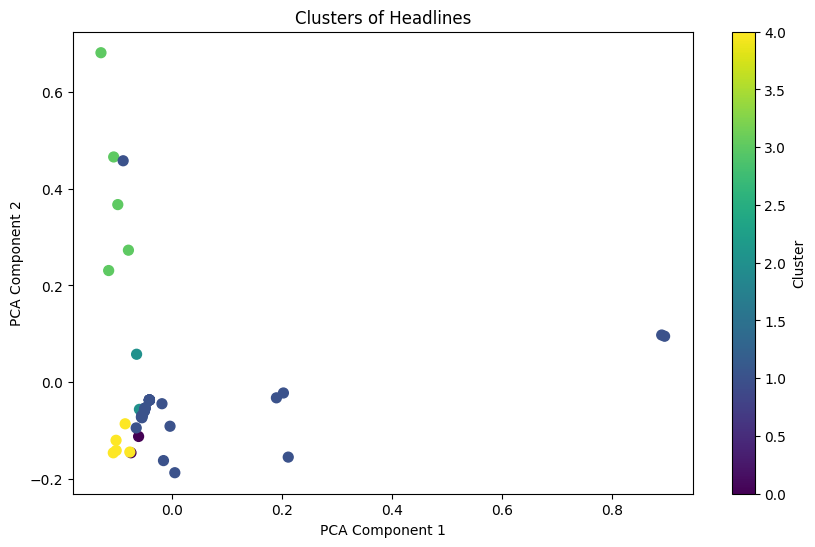

Clustered data saved to 'bbc_headlines_clustered.csv'.


In [10]:
def preprocess_data(df):
    # Remove duplicates and nulls
    df = df.drop_duplicates(subset="Headline").dropna(subset=["Headline"])
    
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    df["Processed"] = df["Headline"].apply(
        lambda x: " ".join(word for word in x.split() if word.lower() not in stop_words)
    )
    
    return df

def cluster_headlines(df, n_clusters=5):
    # Convert headlines to TF-IDF features
    vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
    X = vectorizer.fit_transform(df["Processed"])
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df["Cluster"] = kmeans.fit_predict(X)
    
    return df, kmeans, vectorizer

def summarise_clusters(df, kmeans, vectorizer):
    # Get top terms for each cluster
    feature_names = vectorizer.get_feature_names_out()
    cluster_summaries = []
    for cluster_idx, cluster_center in enumerate(kmeans.cluster_centers_):
        top_feature_indices = cluster_center.argsort()[-10:][::-1]
        top_terms = [feature_names[i] for i in top_feature_indices]
        sample_headlines = df[df["Cluster"] == cluster_idx]["Headline"].head(3).tolist()
        cluster_summaries.append({"Cluster": cluster_idx, "Top Terms": top_terms, "Sample Headlines": sample_headlines})
    
    return cluster_summaries

def visualise_clusters(df, kmeans, vectorizer):
    # Reduce dimensions using PCA
    X = vectorizer.transform(df["Processed"])
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X.toarray())
    
    # Plot clusters
    plt.figure(figsize=(10, 6))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df["Cluster"], cmap="viridis", s=50)
    plt.title("Clusters of Headlines")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label="Cluster")
    plt.show()

def run_pipeline():
    print("Scraping BBC headlines...")
    headlines_df = scrape_bbc_headlines()
    print(f"Scraped {len(headlines_df)} headlines.")
    
    print("Preprocessing data...")
    processed_df = preprocess_data(headlines_df)
    
    print("Clustering headlines...")
    clustered_df, kmeans, vectorizer = cluster_headlines(processed_df, n_clusters=5)
    
    print("Summarising clusters...")
    cluster_summaries = summarise_clusters(clustered_df, kmeans, vectorizer)
    for summary in cluster_summaries:
        print(f"Cluster {summary['Cluster']}:")
        print(f"  Top Terms: {', '.join(summary['Top Terms'])}")
        print(f"  Sample Headlines: {summary['Sample Headlines']}")
        print("-" * 50)
    
    print("Visualising clusters...")
    visualise_clusters(clustered_df, kmeans, vectorizer)
    
    # Save results to CSV
    clustered_df.to_csv("bbc_headlines_clustered.csv", index=False)
    print("Clustered data saved to 'bbc_headlines_clustered.csv'.")

# Run the updated pipeline
run_pipeline()
